# Solving phase and frequency matching conditions for $\chi^{(2)}$  with voxels of increasing resolution.

# Applying voxels of increasing resolution to $\chi^{(3)}$.
Refractive index from:

http://refractiveindex.info/?shelf=main&book=LiNbO3&page=Zelmon-o

see also the notebook Dispersion_relation_chi_2_and_interpolations

In [1]:
import sympy as sp
import numpy as np
import scipy.constants
from sympy.utilities.autowrap import ufuncify
import time
from scipy import interpolate

import matplotlib.pyplot as plt
%matplotlib inline

from sympy import init_printing
init_printing() 

In [352]:
def plot_arr(arr):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.asmatrix(arr), interpolation='nearest')
    fig.colorbar(cax)
    plt.show()

In [353]:
## from https://www.andreas-jung.com/contents/a-python-decorator-for-measuring-the-execution-time-of-methods

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print '%r %2.2f sec' % \
              (method.__name__, te-ts)
        return result
    return timed

In [354]:
lambd,omega,omega1,omega2,omega3,omega4 = sp.symbols('lambda omega omega_1 omega_2 omega_3 omega_4')
l2 = lambd **2

def n_symb(pol='o'):
    s = 1.
    if pol == 'o':
        s += 2.6734 * l2 / (l2 - 0.01764)
        s += 1.2290 * l2 / (l2 - 0.05914)
        s += 12.614 * l2 / (l2 - 474.6)
    else:
        s += 2.9804 * l2 / (l2 - 0.02047)
        s += 0.5981 * l2 / (l2 - 0.0666)
        s += 8.9543 * l2 / (l2 - 416.08)
    return sp.sqrt(s)

def k_symb(symbol=omega,pol='o'):
    '''k is accurate for omega inputs between 6-60.'''
    return ((n_symb(pol=pol) * symbol )
                .subs(lambd,scipy.constants.c / (symbol*1e7))) ## / scipy.constants.c

In [355]:
expressions = [k_symb(omega1,pol='o'), k_symb(omega2,pol='o'), k_symb(omega3,pol='e')]

In [356]:
dispersion_difference_function = sum(expressions)
dispersion_difference_function = dispersion_difference_function.subs(omega3,-omega1-omega2)

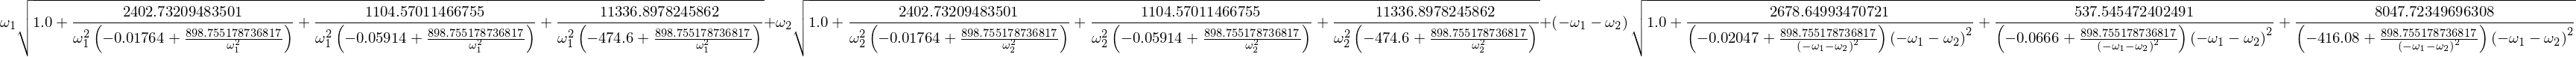

In [357]:
dispersion_difference_function

In [358]:
k_of_omega1_omega2 = ufuncify([omega1,omega2],dispersion_difference_function)

### Find maximum derivative of dispersion_difference_function over a range. This could be used as a bound for $\epsilon$ to guarantee results.

In [359]:
def find_max_der(expression,symbol,input_range):
    expr_der = sp.diff(expression,symbol)
    expr_def_func = ufuncify([symbol],expr_der)
    return max(abs(expr_def_func(input_range)))

In [360]:
## Apply the triangle inequality over a range of omegas

omegas = np.asarray([6.+ i*5e-2 for i in range(1+int(1e3))])
max_derivative = sum([find_max_der(exp,om,omegas) for om,exp in zip([omega1,omega2,omega3],expressions)])

In [361]:
max_derivative

## Methods for systematic search over ranges

### Definitions:
`base` -- The number base to use, i.e. the factor to increase the grid resolution at each step.
`starting_i` -- index of starting step. `0` means we use a grid of size `base` by `base`.
`max_i` -- final index.
`eps` -- desired resolution at step max_i

### Description 

To look for solutions more efficiently, we can recursively enhance the resolution of the grid in which we are looking. At each step, decrease the cutoff `eps_current` by some factor (for now let's make it `base`). For the set of voxels in each step that are close enough to a solution of the equation, increase the resolution by a factor of `base` and examine the resulting smaller voxels. Continue until the last step.

In [362]:
eps = 0.00002
starting_i = 0
max_i = 4
base = 10

In [363]:
@timeit
def setup_ranges(max_i,base):
    ranges= {}
    for i in range(max_i+1):
        ranges[i] = np.linspace(6.,11.,1+pow(base,i+1))
    return ranges

In [364]:
@timeit
def initial_voxels(max_i,base,starting_i,eps):
    solution_containing_voxels = {}
    eps_current = eps * pow(base,max_i-starting_i)
    solution_containing_voxels[starting_i] = {}
    
    for i1,om1 in enumerate(ranges[starting_i]):
        for i2,om2 in enumerate(ranges[starting_i]):
            err = k_of_omega1_omega2(om1,om2)
            if abs(err) < eps_current:
                solution_containing_voxels[starting_i][i1,i2] = err
    return solution_containing_voxels

In [365]:
@timeit
def add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels):
    for i in range(starting_i+1,max_i+1):
        eps_current = eps * pow(base,max_i-i)
        solution_containing_voxels[i] = {}
        for (i1,i2) in solution_containing_voxels[i-1]:
            step_size = int(base/2)
            max_length = pow(base,i+1)
            for i1_new in range(max(0,i1*base-step_size),min(max_length,i1*base+step_size+1)):
                for i2_new in range(max(0,i2*base-step_size),min(max_length,i2*base+step_size+1)):
                    err = k_of_omega1_omega2(ranges[i][i1_new],ranges[i][i2_new])
                    if abs(err) < eps_current:
                        solution_containing_voxels[i][i1_new,i2_new] = err 

In [366]:
@timeit
def plot_voxels(solution_containing_voxels,i):
    voxels = np.zeros((1+pow(base,i+1),1+pow(base,i+1)))
    for (i1,i2) in solution_containing_voxels[i]:
        voxels[i1,i2] = 1
    plot_arr(voxels)

In [367]:
ranges = setup_ranges(max_i,base)

'setup_ranges' 0.00 sec


In [368]:
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)

'initial_voxels' 0.00 sec


In [369]:
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'add_high_res_voxels' 13.59 sec


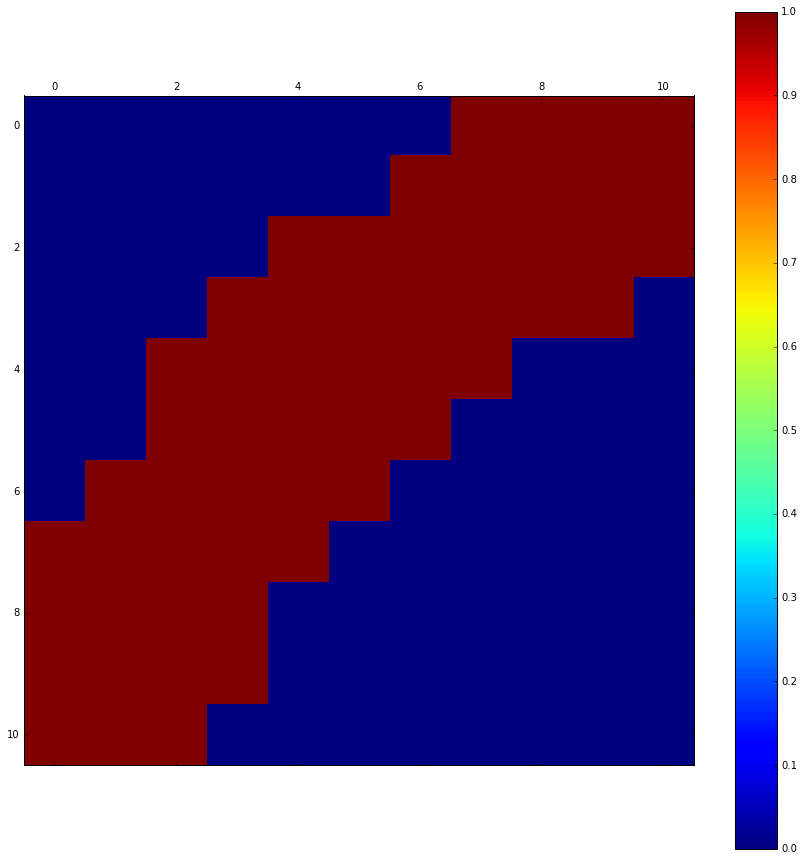

'plot_voxels' 0.55 sec


In [370]:
plot_voxels(solution_containing_voxels,0)

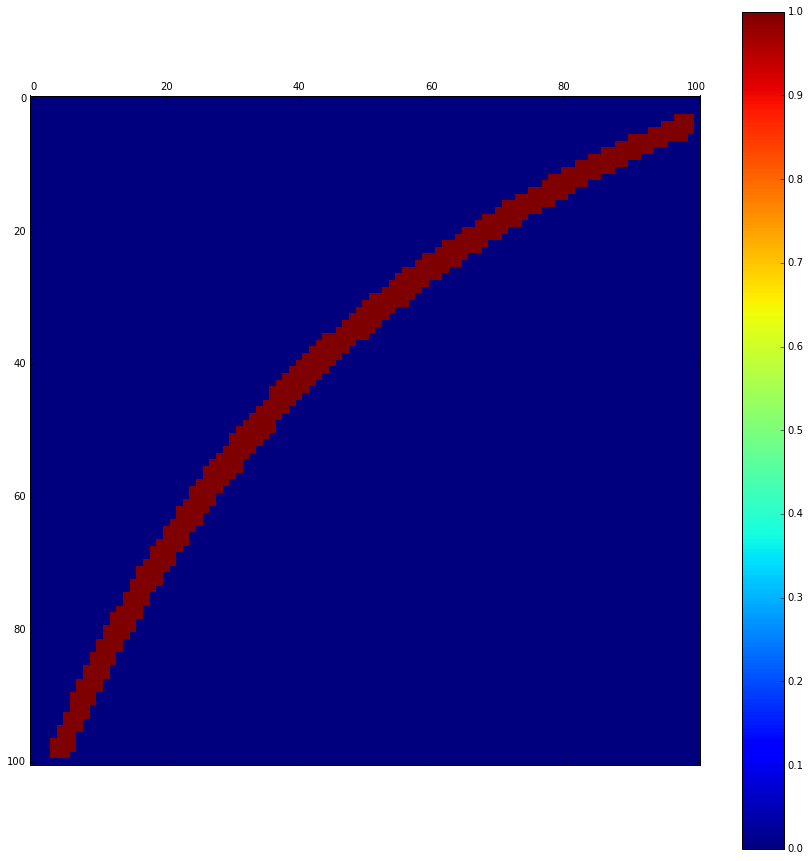

'plot_voxels' 0.55 sec


In [371]:
plot_voxels(solution_containing_voxels,1)

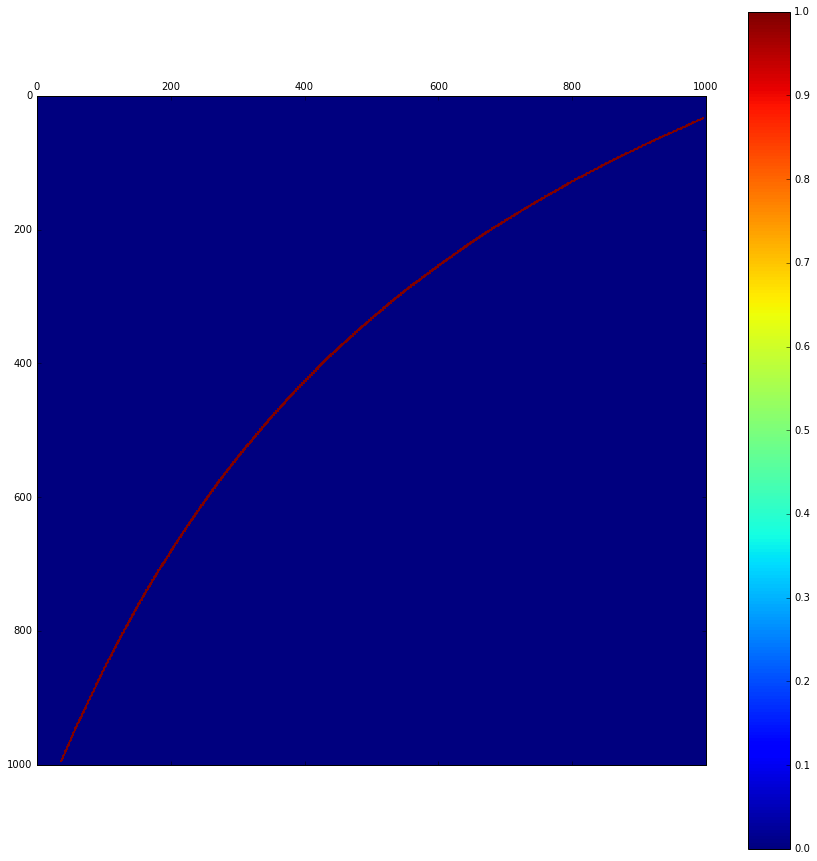

'plot_voxels' 0.67 sec


In [372]:
plot_voxels(solution_containing_voxels,2)

In [245]:
## Number of solutions found for each resolution:

for i in range(0,5):
    print len(solution_containing_voxels[i])

55
529
5339
53349
533391


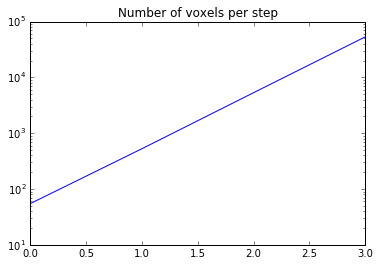

In [246]:
## Number of solutions found for each resolution:
plt.title('Number of voxels per step')
plt.semilogy([(len(solution_containing_voxels[i])) for i in range(0,max_i)])

## Different bases comparison

### Base 10

In [526]:
eps = 0.006
starting_i = 0
max_i = 2
base = 10

In [527]:
## maximum grid length:
1+pow(base,max_i+1)

In [528]:
ranges = setup_ranges(max_i,base)
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'setup_ranges' 0.00 sec
'initial_voxels' 0.00 sec
'add_high_res_voxels' 0.41 sec


In [529]:
## Number of solutions found for each resolution:

for i in range(0,max_i+1):
    print len(solution_containing_voxels[i])

117
1582
16012


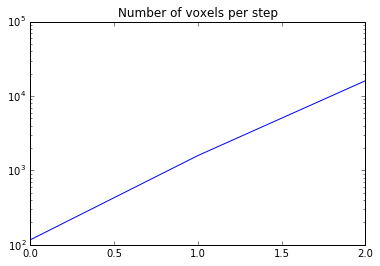

In [530]:
## Number of solutions found for each resolution:
plt.title('Number of voxels per step')
plt.semilogy([(len(solution_containing_voxels[i])) for i in range(0,max_i+1)])

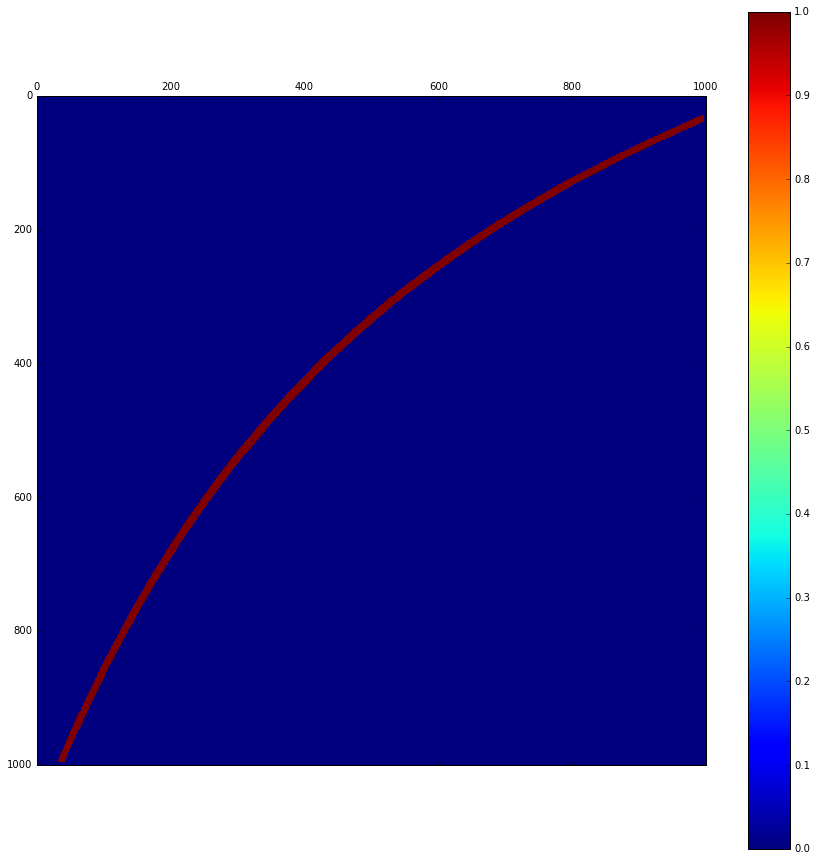

'plot_voxels' 0.67 sec


In [531]:
plot_voxels(solution_containing_voxels,max_i)

### Base 2

In [283]:
eps = 0.006
starting_i = 0
max_i = 9
base = 2

In [284]:
## maximum grid length:
1+pow(base,max_i+1)

In [273]:
ranges = setup_ranges(max_i,base)
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'setup_ranges' 0.00 sec
'initial_voxels' 0.00 sec
'add_high_res_voxels' 0.43 sec


In [274]:
## Number of solutions found for each resolution:

for i in range(0,max_i+1):
    print len(solution_containing_voxels[i])

9
16
64
205
483
1029
2093
4205
8435
16873


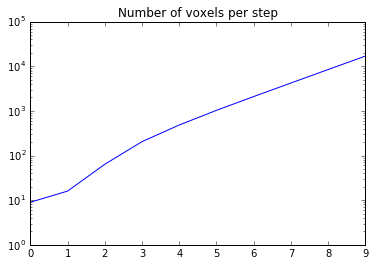

In [275]:
## Number of solutions found for each resolution:
plt.title('Number of voxels per step')
plt.semilogy([(len(solution_containing_voxels[i])) for i in range(0,max_i+1)])

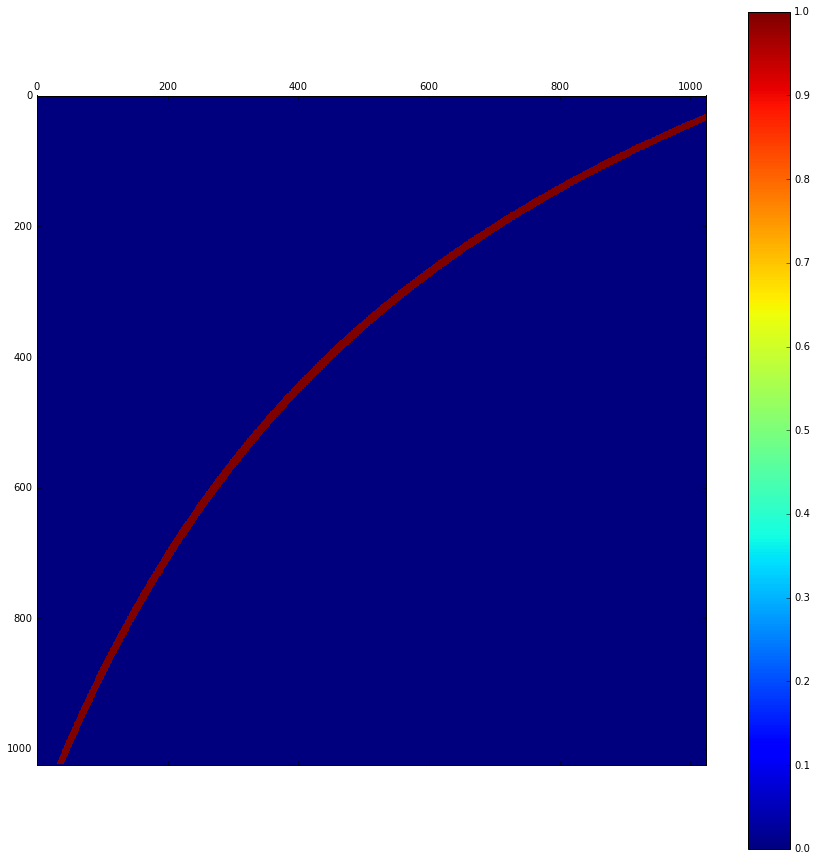

'plot_voxels' 0.64 sec


In [276]:
plot_voxels(solution_containing_voxels,max_i)

## Discussion

The number of solution voxels increases by a factor of `base` at each step. This happens because the function being optimize is close to linear near the solutions and because we decrease `eps_current` by a factor of `base` at each step. As a result, the total number of voxels increases by a factor of `base**2` at each step, but the thickness of the solution voxel surface decreases by a factor of `base`.

The cost of the algorithm is dominated by the last step. This is because the number of voxels increases approximately by a factor of `base` at each step, and the computational cost at each step is the number of voxels from the previous step multiplied by `base**2`. As such, the algorithm runtime is essentially the number of solution points. Notice in the above experiments the runtime was similar for different bases used. 

A more careful analysis assuming a large number of points and the scaling described above gives a geometric series for the runtime, where the sum starts at the last step ($b$ stands for `base` and $p$ stands for number of points):
\begin{align}
b^2(\frac{p}{b} + \frac{p}{b^2} + ...)
=
p\left( b + 1 + \frac{1}{b} + ...\right)
\approx \frac{pb^2}{b-1}.
\end{align}

The other factor contributing to the runtime is breaking away from the scaling law in the above discussion. 

# Using the same technique for $\chi^{(3)}$.

Let's extend the above search technique to using four-wave mixing.

The problems here will be larger, so runtime may be more important. For this reason, I tested different values of epsilon at each stage. Using a smaller epsilon will improve the runtime, but may miss correct solutions. Compare the number of solutions and runtime to the methods used in the notebook Dispersion_relation_two_approaches. The complexity is essentially linear in the number of solutions, but here the constant factor may be large if epsilon is not chosen carefully at each step. For this reason one may prefer to use the other techniques for $\chi^{(3)}$ problems. The number of solutions in the method below converges to the number of solutions using the other two methods.

In [467]:
eps = 2e-4
starting_i = 0
max_i = 1
base = 10

In [468]:
relative_scalings = [4,4,10]

In [469]:
phi1_min = 30.
phi1_max = 34.
ranges1 = {}
for i in range(0,2):
    ranges1[i] = np.linspace(phi1_min,phi1_max,relative_scalings[0]*pow(base,i+1)+1)

phi2_min = -13
phi2_max = -9
ranges2 = {}
for i in range(0,2):
    ranges2[i] = np.linspace(phi2_min,phi2_max,relative_scalings[1]*pow(base,i+1)+1)

omega3_min = -26.
omega3_max = -16.
ranges3 = {}
for i in range(0,2):
    ranges3[i] = np.linspace(omega3_min,omega3_max,relative_scalings[2]*pow(base,i+1)+1)

print len(ranges1[1]),len(ranges2[1]),len(ranges3[1])

401 401 1001


In [470]:
phi1, phi2 = sp.symbols('phi_1 phi_2')

In [471]:
ex1 = (k_symb(omega1,pol='e')+k_symb(omega2,pol='e')).expand().subs({omega1:(phi1 + phi2)/2, omega2: (phi1-phi2)/2})

In [472]:
ex2 = -(k_symb(omega3,pol='e')+k_symb(omega4,pol='e')).expand().subs(omega4,-phi1-omega3)

In [473]:
f_phi12_omega3 =ufuncify([phi1,phi2,omega3], ex1-ex2)

In [510]:
@timeit
def initial_voxels_4wv(max_i,base,starting_i,eps,eps_factor = None):

    if eps_factor is None:
        eps_factor = pow(base,max_i-starting_i)
    eps_current = eps * eps_factor
        
    solution_containing_voxels = {}
    solution_containing_voxels[starting_i] = {}
    
    for i1,om1 in enumerate(ranges1[starting_i]):
        for i2,om2 in enumerate(ranges2[starting_i]):
            for i3,om3 in enumerate(ranges3[starting_i]):
                err = f_phi12_omega3(om1,om2,om3)
                if abs(err) < eps_current:
                    solution_containing_voxels[starting_i][i1,i2,i3] = err
    return solution_containing_voxels

In [511]:
@timeit
def add_high_res_voxels_4wv(max_i,base,starting_i,eps,solution_containing_voxels):
    for i in range(starting_i+1,max_i+1):
        eps_current = eps * pow(base,max_i-i)
        solution_containing_voxels[i] = {}
        for (i1,i2,i3) in solution_containing_voxels[i-1]:
            step_size = int(base/2)
            max_length = pow(base,i+1)
            for i1_new in range(max(0,i1*base-step_size),min(relative_scalings[0]*max_length,i1*base+step_size+1)):
                for i2_new in range(max(0,i2*base-step_size),min(relative_scalings[1]*max_length,i2*base+step_size+1)):
                    for i3_new in range(max(0,i3*base-step_size),min(relative_scalings[2]*max_length,i3*base+step_size+1)):
                        err = f_phi12_omega3(ranges1[i][i1_new],ranges2[i][i2_new],ranges3[i][i3_new])
                        if abs(err) < eps_current:
                            solution_containing_voxels[i][i1_new,i2_new,i3_new] = err 

In [512]:
eps_factors = [1.5,2.,2.5,3.,3.5,4.]
num_found = {}

In [513]:
for eps_factor in eps_factors:
    solution_containing_voxels_4wv = initial_voxels_4wv(max_i,base,starting_i,eps,eps_factor = eps_factor)
    print 'big voxels: ', len(solution_containing_voxels_4wv[0].keys())
    add_high_res_voxels_4wv(max_i,base,starting_i,eps,solution_containing_voxels_4wv)
    num_found[eps_factor] = len(solution_containing_voxels_4wv[1].keys())
    print 'little voxels: ', num_found[eps_factor]

'initial_voxels_4wv' 0.39 sec
big voxels:  6184
'add_high_res_voxels_4wv' 27.07 sec
little voxels:  3766866
'initial_voxels_4wv' 0.42 sec
big voxels:  7776
'add_high_res_voxels_4wv' 33.33 sec
little voxels:  3979085
'initial_voxels_4wv' 0.38 sec
big voxels:  9295
'add_high_res_voxels_4wv' 38.83 sec
little voxels:  4094222
'initial_voxels_4wv' 0.38 sec
big voxels:  10772
'add_high_res_voxels_4wv' 45.37 sec
little voxels:  4158570
'initial_voxels_4wv' 0.40 sec
big voxels:  12168
'add_high_res_voxels_4wv' 50.01 sec
little voxels:  4193377
'initial_voxels_4wv' 0.40 sec
big voxels:  13556
'add_high_res_voxels_4wv' 55.12 sec
little voxels:  4208929


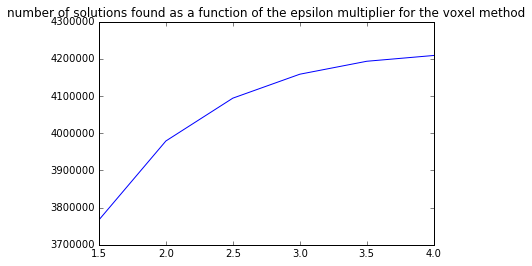

In [515]:
plt.title('number of solutions found as a function of the epsilon multiplier for the voxel method')
plt.plot(eps_factors, [num_found[eps] for eps in eps_factors] )

## Experimental Stuff

In [534]:
eps = 0.006
starting_i = 0
max_i = 2
base = 10

In [535]:
ranges = setup_ranges(max_i,base)
solution_containing_voxels = initial_voxels(max_i,base,starting_i,eps)
add_high_res_voxels(max_i,base,starting_i,eps,solution_containing_voxels)

'setup_ranges' 0.00 sec
'initial_voxels' 0.00 sec
'add_high_res_voxels' 0.38 sec


In [517]:
import itertools
list_of_pm_arr = list(itertools.product([-1, 1], repeat=3))

In [518]:
list_of_pm_arr

In [543]:
import random

In [547]:
random.random()

In [522]:
ranges[0]

array([  6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ,
        10.5,  11. ])

In [540]:
print len(solution_containing_voxels[2].keys())

16012


In [562]:
solution_containing_voxels[0]

In [541]:
ranges[0]

array([  6. ,   6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ,
        10.5,  11. ])

In [555]:
scale = 0.1
Delta = ranges[0][1] - ranges[0][0]
ranges_special = [num+random.random()*scale for num in ranges[0]]

In [569]:
values = 2*[round(el/Delta)*Delta for el in ranges_special]

In [570]:
inputs = 2*ranges_special

In [571]:
def make_dict_values_to_lists_of_inputs(values,inputs):
    D = {}
    for k, v in zip(values,inputs):
        D.setdefault(k, []).append(v)
    return D

In [572]:
make_dict_values_to_lists_of_inputs(values,inputs)